# First example of causal discovery

### Goal of this notebook: 

show that causal discovery using CMI queries works for linear, continuous-valued data and three different structures.

The logPDF of the observation function is computed as follows:

$ \sum_{a,b,c} \log P\bigg(CMI(a ,b \mid c) > \epsilon \bigg) +
\sum_{x,y,z}\log P\bigg(\neg\big(CMI(x ,y \mid z) > \epsilon \big)\bigg)$

where $\{a, b, c\}$ and $\{ x, y, z\}$ are dependent or independent nodes in the causal DAG to learn. A sampled DAG structure determines which
independence statements are true and which false, therefore determining which of the binary CMI probabilities needs to be negated ($\neg$). Here by negated we mean:

$1 - P\bigg(\big(CMI(x ,y \mid z)\bigg) = P\bigg(\neg\big(CMI(x ,y \mid z)\bigg)$.

This allows one to compute the  equivalence classes of causal DAG as posterior distributions over possible structures (assuming causal 
faithfulness).

In the following, this notebooks demonstrates that this premise is true.

### Table of contents
1. Synthetic Data
2. BDB - Population and Analysis 
3. Causal discovery for  two independent nodes
4. Causal discovery for  two dependent nodes
5. Causal discovery for a V-structure
5. Causal discovery for a common-cause-structure
6. Known issues

In [1]:
%%capture
from synth_data_generator import generate_linear_data 
%load_ext iventure.magics
%matplotlib inline

## 1. Synthetic Data


The following graphical model is used to generate N datapoints: 

![title](img/causal_example.png)
__Figure 1: Causal graphical model.__ The model above was used for generating synthetic data. 

Further, the following linear generative system was used:

### (i)

$ a  \sim \mathcal{N}(0,2)$

$ b  \sim \mathcal{N}(0,2)$

### (ii)

$ c  \sim \mathcal{N}(0,2)$

$ d  \sim \mathcal{N}(3c,1)$

### (iii)

$ e  \sim \mathcal{N}(0, 2)$

$ f  \sim \mathcal{N}(0, 2)$

$ g  \sim \mathcal{N}(2e + 2f, 1)$

### (vi)

$ h  \sim \mathcal{N}(0, 2)$

$ i  \sim \mathcal{N}(2h, 1)$

$ j  \sim \mathcal{N}(2h, 1)$


##### We generate $N$ data points:

In [7]:
N = 100

### Plotting the population
Below, we plot all data generated with using the generator described above.
Variables (a) to (g) are all part of the data table that is used for the population below.

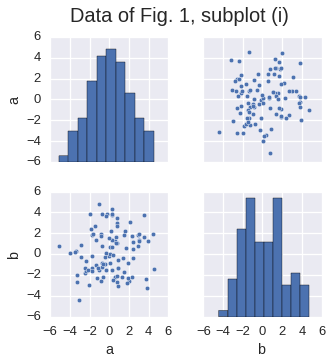

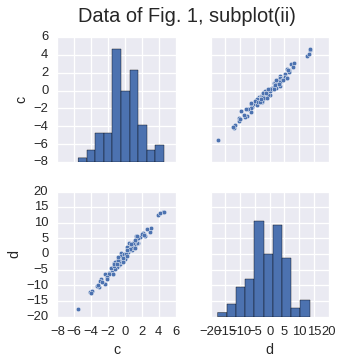

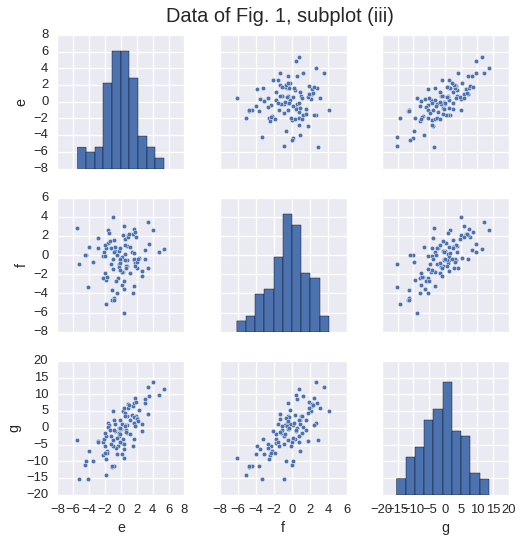

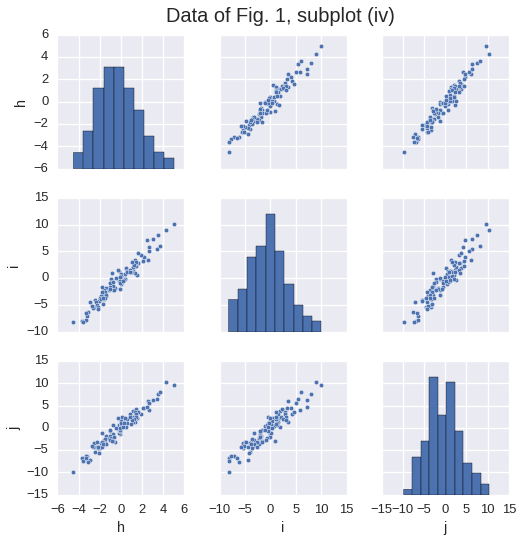

In [8]:
generate_linear_data(N)

## 2. BDB - Population and Analysis 

Below, we create and analyze a population for the data displayed above. For
this population, we will later compile a DAG to a set of queries to assess
the probability of mutual information as implied by the (conditional) dependence implied by the DAG. For now, we only consider cases where data generator and DAG are causally "faithful".

In [2]:
%bayesdb -j bdb_files/causal_linear.bdb

u'Loaded: bdb_files/causal_linear.bdb'

In [10]:
%%mml
DROP METAMODEL IF EXISTS causal_linear_cc ;
DROP POPULATION IF EXISTS causal_linear_population;
DROP TABLE IF EXISTS causal_linear_table;
CREATE TABLE causal_linear_table FROM 'csv_files/causal_linear.csv';
CREATE POPULATION causal_linear_population FOR  causal_linear_table
    WITH SCHEMA(MODEL a, b, c, d, e, f, g, h, i, j AS NUMERICAL);
CREATE METAMODEL causal_linear_cc FOR  causal_linear_population 
    WITH BASELINE crosscat;
INITIALIZE 50 MODELS FOR causal_linear_cc; 

""


In [11]:
%mml ANALYZE causal_linear_cc FOR 500 ITERATION WAIT(OPTIMIZED);

Completed: 500 iterations in 260.716870 seconds.
Completed: 500 iterations in 260.788534 seconds.
Completed: 500 iterations in 260.764418 seconds.
Completed: 500 iterations in 261.030150 seconds.
Completed: 500 iterations in 261.005128 seconds.
Completed: 500 iterations in 261.504360 seconds.
Completed: 500 iterations in 261.550636 seconds.
Completed: 500 iterations in 261.539144 seconds.
Completed: 500 iterations in 261.623849 seconds.
Completed: 500 iterations in 261.742200 seconds.
Completed: 500 iterations in 261.963012 seconds.
Completed: 500 iterations in 262.018726 seconds.
Completed: 500 iterations in 262.067966 seconds.
Completed: 500 iterations in 262.110896 seconds.
Completed: 500 iterations in 262.186996 seconds.
Completed: 500 iterations in 262.147471 seconds.
Completed: 500 iterations in 262.172296 seconds.
Completed: 500 iterations in 262.166171 seconds.
Completed: 500 iterations in 262.240987 seconds.
Completed: 500 iterations in 262.250035 seconds.
Completed: 500 itera

""


We check that the that dependence probability heatmap looks as expected:

/scratch/ulli/venv/local/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/scratch/ulli/venv/local/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


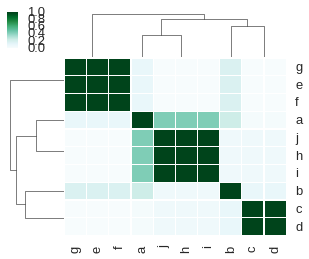

In [12]:
%%bql 
.clustermap 
    ESTIMATE DEPENDENCE PROBABILITY 
        FROM PAIRWISE COLUMNS OF causal_linear_population;

## 3. Causal discovery for  two independent nodes

#### Data as in  Fig. 1 subplot (i).

In [13]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


Below, we define population, metamodel and  .bdb file.

In [14]:
%%venturescript
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";

Next, we define which columns in the data table used for population and metamodel are to be considered for structure learning.

In [15]:
%%venturescript
define list_of_nodes = ["a", "b"];
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

Queries of the following kind are generated: 

In [16]:
query = %venturescript list_of_cmi_queries[1]
print(query)

CREATE TABLE  mi_a_b AS
            SIMULATE
                MUTUAL INFORMATION OF a WITH b
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;


### VentureScript structure learning

In [17]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if (size(list_of_nodes)==1) {
        list_of_nodes
    } else {
        // well, here run into a limitation of
        // venture, namely, [1] + [2] is [3]
        // whereas [1] + [2,3] is [1,2,3], which
        // is the desired behaviour. Therefore,
        // we need another condition to catch 
        // this.
        if(size(list_of_nodes)==2){
           if (flip()) {
                list_of_nodes
           } else {
                [list_of_nodes[1], list_of_nodes[0]]}
           }
         else {                  
             random_index ~ uniform_discrete(0, size(list_of_nodes));
             popped =  pop(list_of_nodes, random_index);
             [popped[0]] + get_causal_ordering(popped[1])
        }
    }
};

assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
   } else {
       flip() 
   }
});

assume DAG = mapv(
    (i) -> {
        mapv((j) -> {edge(real(i), real(j))}, arange(number_nodes))},
    arange(number_nodes));

assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file}
                              );

__CAVEAT:__ The purpose of this notebook is to illustrate that this technique works - I am misusing at least one of Venture's abstractions; namely, I am observing the following:  

In [18]:
%%venturescript
observe observation_function(DAG, ${list_of_nodes}) = list_of_cmi_queries;

Running the following query:
DROP TABLE IF EXISTS mi_a_b;
Running the following query:
CREATE TABLE  mi_a_b AS
            SIMULATE
                MUTUAL INFORMATION OF a WITH b
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;


### Inference
We take 10 MH steps to account for burn in.

In [19]:
%%venturescript
mh(default, all, 10);

Next, we collect 20 samples from the posterior. 
Note that `dag_to_dot_notation` takes the matrix form of a DAG and turns
it into dot notation, i.e. `(a)->(b)` for a DAG that has one edge from 
column c to do d or `no edge` if all entries in the DAG matrix are false.

In [20]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 1);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(20)));

### Result

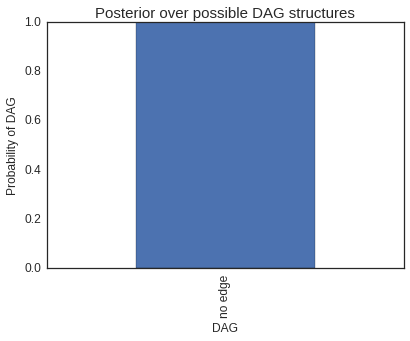

In [21]:
%%venturescript
plot_posterior_dags(posterior_samples);

## 4. Causal discovery for  two dependent nodes

#### Data as in  Fig. 1 subplot (ii).

In [22]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


In [23]:
%%venturescript
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";

Next, we define which columns (this time, "c" and "d") in the data table used for population and metamodel are to be considered for structure learning.

In [24]:
%%venturescript
define list_of_nodes = ["c", "d"];
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

### VentureScript structure learning

(same program as above. The SP that implements the observation function, has an unincorporate method which is currently broken. Therefore, I have to run the model to sample DAGs from scratch.) 

In [25]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if(size(list_of_nodes)==1) {
        list_of_nodes}
    else {
        if(size(list_of_nodes)==2){// well, here run into a limitation of
                                   // venture, namely, [1] + [2] is [3]
                                   // whereas [1] + [2,3] is [1,2,3], which
                                   // is the desired behaviour. Therefore,
                                   // we need another condition to catch 
                                   // this.
            if(flip()) {list_of_nodes} else {[list_of_nodes[1], list_of_nodes[0]]}}
        else {                  
            random_index ~ uniform_discrete(0, size(list_of_nodes));
            popped =  pop(list_of_nodes, random_index);
            [popped[0]] + get_causal_ordering(popped[1])}}
    
};

assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
        }
   else {
            flip() 
        }});

assume DAG = mapv((i) -> {
        mapv((j) -> {edge(real(i),real(j))}, arange(number_nodes))},
        arange(number_nodes));

assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file}
                              );

__CAVEAT:__ The purpose of this notebook is to illustrate that this technique works - I am misusing at least one of Venture's abstractions; namely, I am observing the following:  

In [26]:
%%venturescript
observe observation_function(DAG, ${list_of_nodes}) = list_of_cmi_queries;

Running the following query:
DROP TABLE IF EXISTS mi_c_d;
Running the following query:
CREATE TABLE  mi_c_d AS
            SIMULATE
                MUTUAL INFORMATION OF c WITH d
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;


### Inference

We take 50 MH steps to account for burn in.

In [27]:
%%venturescript
mh(default, all, 50);

In [28]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 1);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(100)));


Next, we collect 100 samples from the posterior. 
Note that `dag_to_dot_notation` takes the matrix form of a DAG and turns
it into dot notation, i.e. `(c)->(d)` for a DAG that has one edge from column c to do d.

Also note that this result is created with only one chain.

### Result

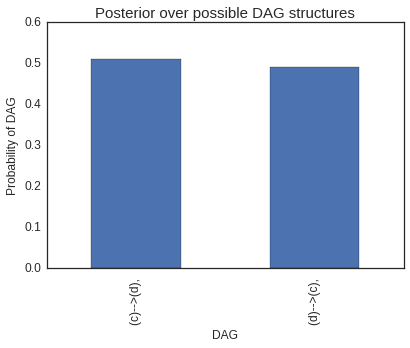

In [29]:
%%venturescript
plot_posterior_dags(posterior_samples);

## 5. Causal discovery for  a V-structure

#### Data as in  Fig. 1 subplot (iii).

In [30]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


In [31]:
%%venturescript
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";

In [32]:
%%venturescript
define list_of_nodes = ["e", "f", "g"];
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

Now the list of queries also contains queries for conditional mutual information

### VentureScript structure learning

(same program as above. The SP that implements the observation function, has an unincorporate method which is currently broken. Therefore, I have to run the model to sample DAGs from scratch.) 

In [34]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if(size(list_of_nodes)==1) {
        list_of_nodes}
    else {
        if(size(list_of_nodes)==2){// well, here run into a limitation of
                                   // venture, namely, [1] + [2] is [3]
                                   // whereas [1] + [2,3] is [1,2,3], which
                                   // is the desired behaviour. Therefore,
                                   // we need another condition to catch 
                                   // this.
            if(flip()) {list_of_nodes} else {[list_of_nodes[1], list_of_nodes[0]]}}
        else {                  
            random_index ~ uniform_discrete(0, size(list_of_nodes));
            popped =  pop(list_of_nodes, random_index);
            [popped[0]] + get_causal_ordering(popped[1])}}
    
};



assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
        }
   else {
            flip() 
        }});

assume DAG = mapv(
        (i) -> {mapv((j) -> {edge(real(i),real(j))}, arange(number_nodes))},
        arange(number_nodes));

assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file}
                              );

__CAVEAT:__ The purpose of this notebook is to illustrate that this technique works - I am misusing at least one of Venture's abstractions; namely, I am observing the following:  

In [35]:
%%venturescript
observe observation_function(DAG, ${list_of_nodes}) = list_of_cmi_queries;

Running the following query:
DROP TABLE IF EXISTS mi_e_f;
Running the following query:
CREATE TABLE  mi_e_f AS
            SIMULATE
                MUTUAL INFORMATION OF e WITH f
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
Running the following query:
DROP TABLE IF EXISTS mi_e_g;
Running the following query:
CREATE TABLE  mi_e_g AS
            SIMULATE
                MUTUAL INFORMATION OF e WITH g
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
Running the following query:
DROP TABLE IF EXISTS mi_f_g;
Running the following query:
CREATE TABLE  mi_f_g AS
            SIMULATE
                MUTUAL INFORMATION OF f WITH g
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
Running the following query:
DROP TABLE IF EXISTS mi_e_f_given_g;
Running the following query:
CREATE TABLE  mi_e_f_given_g AS
            SIMULATE
                MUTUAL I

### Inference

This time, we run a longer burn-in period (100 transition of resimulation MH).

In [36]:
%%venturescript
mh(default, all, 100);

Next, we collect 50 samples from the posterior. 
Note that `dag_to_dot_notation` takes the matrix form of a DAG and turns
it into dot notation, i.e. `(a)->(b)` for a DAG that has one edge from 
column c to do d or `no edge` if all entries in the DAG matrix are false.

In [37]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 1);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(100)));

### Result

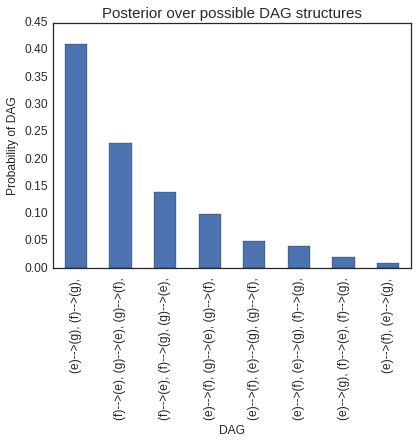

In [38]:
%%venturescript
plot_posterior_dags(posterior_samples);

## 6. Causal discovery for  a common-cause-structure

#### Data as in  Fig. 1 subplot (iv).

In [39]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


In [40]:
%%venturescript
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";

In [41]:
%%venturescript
define list_of_nodes = ["h", "i", "j"];
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

Now the list of queries also contains queries for conditional mutual information

### VentureScript structure learning

(same program as above. The SP that implements the observation function, has an unincorporate method which is currently broken. Therefore, I have to run the model to sample DAGs from scratch.) 

In [42]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if(size(list_of_nodes)==1) {
        list_of_nodes}
    else {
        if(size(list_of_nodes)==2){// well, here run into a limitation of
                                   // venture, namely, [1] + [2] is [3]
                                   // whereas [1] + [2,3] is [1,2,3], which
                                   // is the desired behaviour. Therefore,
                                   // we need another condition to catch 
                                   // this.
            if(flip()) {list_of_nodes} else {[list_of_nodes[1], list_of_nodes[0]]}}
        else {                  
            random_index ~ uniform_discrete(0, size(list_of_nodes));
            popped =  pop(list_of_nodes, random_index);
            [popped[0]] + get_causal_ordering(popped[1])}}
    
};

assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
        }
   else {
            flip() 
        }});

assume DAG = mapv(
        (i) -> {mapv((j) -> {edge(real(i),real(j))}, arange(number_nodes))},
        arange(number_nodes));

assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file}
                              );

__CAVEAT:__ The purpose of this notebook is to illustrate that this technique works - I am misusing at least one of Venture's abstractions; namely, I am observing the following:  

In [43]:
%%venturescript
observe observation_function(DAG, ${list_of_nodes}) = list_of_cmi_queries;

Running the following query:
DROP TABLE IF EXISTS mi_h_i;
Running the following query:
CREATE TABLE  mi_h_i AS
            SIMULATE
                MUTUAL INFORMATION OF h WITH i
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
Running the following query:
DROP TABLE IF EXISTS mi_h_j;
Running the following query:
CREATE TABLE  mi_h_j AS
            SIMULATE
                MUTUAL INFORMATION OF h WITH j
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
Running the following query:
DROP TABLE IF EXISTS mi_i_j;
Running the following query:
CREATE TABLE  mi_i_j AS
            SIMULATE
                MUTUAL INFORMATION OF i WITH j
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
Running the following query:
DROP TABLE IF EXISTS mi_h_i_given_j;
Running the following query:
CREATE TABLE  mi_h_i_given_j AS
            SIMULATE
                MUTUAL I

### Inference

This time, we run a longer burn-in period (100 transition of resimulation MH).

In [44]:
%%venturescript
mh(default, all, 100);

Next, we collect 50 samples from the posterior. 
Note that `dag_to_dot_notation` takes the matrix form of a DAG and turns
it into dot notation, i.e. `(a)->(b)` for a DAG that has one edge from 
column c to do d or `no edge` if all entries in the DAG matrix are false.

In [49]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 10);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(50)));

### Result

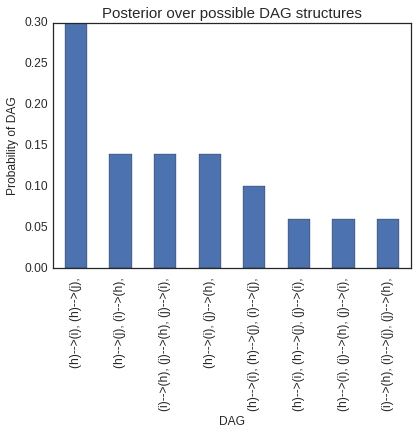

In [50]:
%%venturescript
plot_posterior_dags(posterior_samples);

## 7. Known issues:

- the `unincorporate` of the SP that implements the observation function for causal discovery is currently broken, therefore, we have to start a new RIPL
	and repeat the cell with the structure learning program three times,
    one for each set of of columns we look at.
-  For the implementation of the observation function I am miss-using abstractions. It is clear to me that this observation function should not observe CMI but the actual, raw data. Then, we can use crosscat to simulate. 
	I decided to leave it in this state to discuss and get feedback.
- The current implementation is slow - I need to think about good inference 
	schemes to speed up causal discovery.

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [4]:
hist_df %bql SELECT * FROM mi_h_i

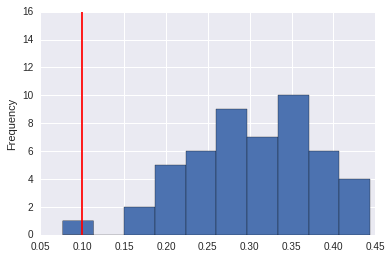

In [11]:
hist_df = %bql SELECT * FROM mi_e_g
hist_df["mi"].plot(kind="hist")
plt.plot([0.1]*100, np.linspace(0, 16,100), c="r")

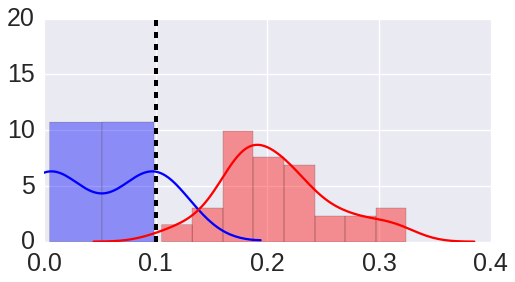

In [72]:
fig = plt.figure(figsize=(8,4))
plot = fig.add_subplot(111)
hist_df = %bql SELECT * FROM mi_e_f_given_g
sns.distplot(hist_df[hist_df["mi"]<0.1]["mi"], color="b")
sns.distplot(hist_df[hist_df["mi"]>0.1]["mi"], color="r")
plt.plot([0.1]*100, np.linspace(0, 20,100), c="k", linewidth=4, linestyle="--")
plt.xlim([0,0.4])
plt.ylim([0,20])
plt.xlabel("")
plt.locator_params(nbins=4)

plot.tick_params(axis='both', which='major', labelsize=25)
plot.tick_params(axis='both', which='minor', labelsize=12)

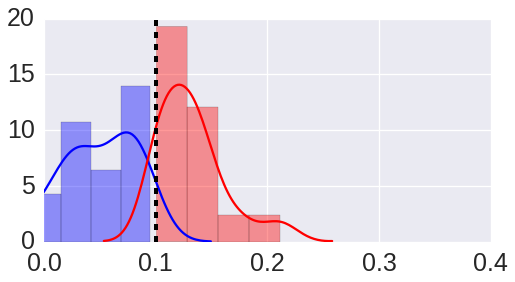

In [73]:
fig = plt.figure(figsize=(8,4))
plot = fig.add_subplot(111)
hist_df = %bql SELECT * FROM mi_e_f
sns.distplot(hist_df[hist_df["mi"]<0.1]["mi"], color="b")
sns.distplot(hist_df[hist_df["mi"]>0.1]["mi"], color="r")
plt.plot([0.1]*100, np.linspace(0, 20,100), c="k", linewidth=4, linestyle="--")
plt.xlim([0,0.4])
plt.ylim([0,20])
plt.xlabel("")
plt.locator_params(nbins=4)

plot.tick_params(axis='both', which='major', labelsize=25)
plot.tick_params(axis='both', which='minor', labelsize=12)

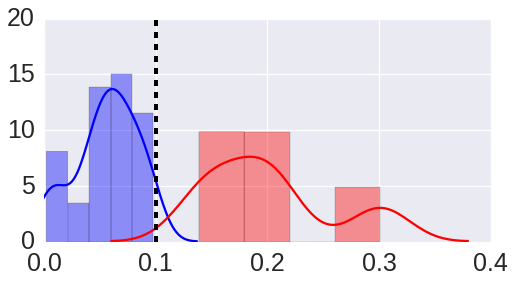

In [74]:
fig = plt.figure(figsize=(8,4))
plot = fig.add_subplot(111)
np.random.seed(0)
synth_data= np.random.uniform(low=0, high=0.1, size=(45,)).tolist() +\
    np.random.uniform(low=0.1, high=0.4, size=(5,)).tolist()
hist_df = pd.DataFrame({"mi":synth_data})
sns.distplot(hist_df[hist_df["mi"]<0.1]["mi"], color="b")
sns.distplot(hist_df[hist_df["mi"]>0.1]["mi"], color="r")
plt.plot([0.1]*100, np.linspace(0, 20,100), c="k", linewidth=4, linestyle="--")
plt.xlim([0,0.4])
plt.ylim([0,20])
plt.xlabel("")
plt.locator_params(nbins=4)

plot.tick_params(axis='both', which='major', labelsize=25)
plot.tick_params(axis='both', which='minor', labelsize=12)